# Twitter Bot or Not?: First Simple Model

Predicting whether or not a Twitter account is a bot or human using account-level information. 
* Target variable: Bot or not? 
    * Bot = 1
    * Human = 0 

**Notes**
* Dataset source: [Twitter Bot Accounts](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts?select=twitter_human_bots_dataset.csv)
* Feature notes -- 'friends'?     
    * `friends_count` = Following
    * `followers_count` = Followers

In [1]:
# Basics
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model support
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, 
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)

## Data import and setup

In [2]:
raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

In [3]:
# drop funny index column
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [4]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]


In [5]:
del raw_df

In [6]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['followers_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [7]:
df.head()

,bot,screen_name,created_at,hour_created,verified,location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,popularity,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.0,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,1.0,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.0,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,"Birmingham, AL",1,en,1,0,...,0.0,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,0.354
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,"England, United Kingdom",1,en,0,0,...,240.0,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.036


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   bot                     37438 non-null  int64         
 1   screen_name             37438 non-null  object        
 2   created_at              37438 non-null  datetime64[ns]
 3   hour_created            37438 non-null  int64         
 4   verified                37438 non-null  int64         
 5   location                37435 non-null  object        
 6   geo_enabled             37438 non-null  int64         
 7   lang                    29481 non-null  object        
 8   default_profile         37438 non-null  int64         
 9   default_profile_image   37438 non-null  int64         
 10  favourites_count        37438 non-null  int64         
 11  followers_count         37438 non-null  int64         
 12  friends_count           37438 non-null  int64 

## Unbalanced data? 

In [9]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print("Bots / Total %: ", (num_bots / len(df)) * 100)

Number of bots:  12425
Number of humans:  25013
Bots / Total %:  33.18820449810353


In [10]:
# humans_to_remove = num_humans - num_bots
# humans_to_remove = 10000
# humans_to_remove

In [11]:
# df = df.drop(df.query('bot == 0').sample(n=humans_to_remove).index)

# num_bots = len(df[df['bot'] == 1])
# num_humans = len(df[df['bot'] == 0])

# print("Number of bots: ", num_bots)
# print("Number of humans: ", num_humans)
# print("Bots / Total %: ", (num_bots / len(df)) * 100)

## Feature selection & model setup

In [12]:
df.columns

Index(['bot', 'screen_name', 'created_at', 'hour_created', 'verified',
       'location', 'geo_enabled', 'lang', 'default_profile',
       'default_profile_image', 'favourites_count', 'followers_count',
       'friends_count', 'statuses_count', 'average_tweets_per_day',
       'account_age_days', 'avg_daily_followers', 'avg_daily_friends',
       'avg_daily_favorites', 'friends_log', 'followers_log', 'favs_log',
       'avg_daily_tweets_log', 'popularity', 'tweet_to_followers',
       'follower_acq_rate', 'friends_acq_rate', 'favs_rate'],
      dtype='object')

In [13]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            #'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [14]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [15]:
scalar = StandardScaler()

scalar.fit(X)

X_train_scaled = scalar.transform(X)
X_test_scaled = scalar.transform(X_test)

### KNN

In [16]:
ks = range(1, 30)

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=4)

test_errors = np.zeros(len(list(ks)))
acc_scores = np.zeros(len(list(ks)))

for i, k in enumerate(ks):
    
    nn = KNeighborsClassifier(n_neighbors=k)

    nn.fit(X_train_scaled, y_train)
    test_preds = nn.predict(X_val_scaled)
    
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_preds))
    acc_scores[i] = accuracy_score(y_val, test_preds)
    

optimal_k_r2 = list(ks)[np.argmin(test_errors)]
optimal_error = np.min(test_errors)

optimal_k_acc = list(ks)[np.argmax(acc_scores)]
optimal_acc = np.max(acc_scores)

print("RMSE Metric")
print(f'Optimal number of Neighbors: {optimal_k_r2}\nRoot Mean Squared Error: {optimal_error:.2f}')
print('\nAccuracy Metric')
print(f'Optimal number of Neighbors: {optimal_k_acc}\nAccuracy Score: {optimal_acc:.2f}')    

RMSE Metric
Optimal number of Neighbors: 8
Root Mean Squared Error: 0.39

Accuracy Metric
Optimal number of Neighbors: 8
Accuracy Score: 0.85


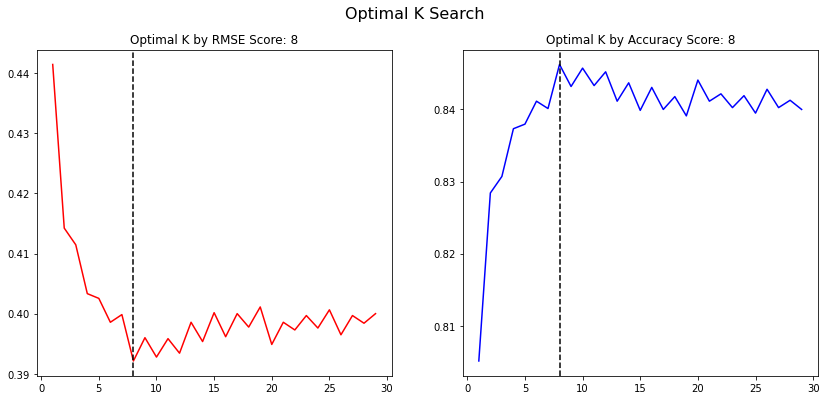

In [17]:
plt.figure(figsize=(14, 6))
plt.suptitle('Optimal K Search', fontsize=16)

# Optimal RMSE
plt.subplot(1, 2, 1)

plt.title('Optimal K by RMSE Score: {}'.format(optimal_k_r2))
plt.plot(list(ks), test_errors, color='red')
plt.axvline(list(ks)[np.argmin(test_errors)], linestyle='--', color='black')

# Optimal accuracy score
plt.subplot(1, 2, 2)

plt.title('Optimal K by Accuracy Score: {}'.format(optimal_k_acc))
plt.plot(list(ks), acc_scores, color='blue')
plt.axvline(list(ks)[np.argmax(acc_scores)], linestyle='--', color='black');

In [18]:
#optimal_k = 8

In [19]:
# Resetting train/test split
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)
X_test_scaled = scalar.transform(X_test)

In [20]:
knn = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

cv_scores = cross_val_score(knn, X_train_scaled, y, cv=3)

print("CV Scores: ", cv_scores)
print("Mean Score: ", cv_scores.mean())

CV Scores:  [0.83630417 0.82927228 0.82630029]
Mean Score:  0.8306255819184741


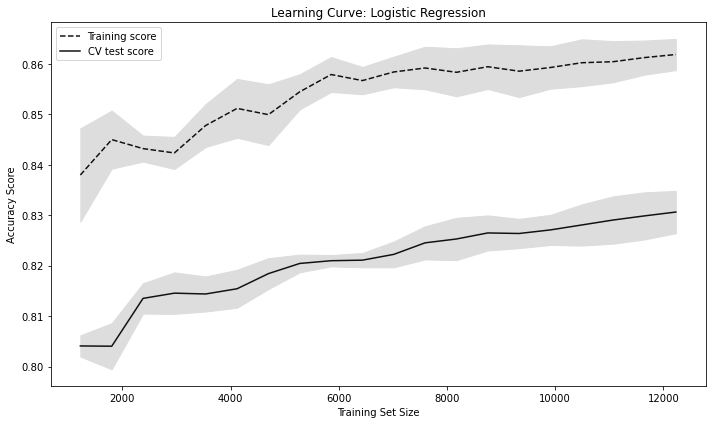

In [21]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(knn, 
                                                        X_train_scaled, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 20))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="CV test score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve: Logistic Regression")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout();

Looks like some overfitting? 

In [22]:
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=4)

In [23]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.8383
Precision: 0.8292
Recall: 0.6670
F1 Score: 0.7393

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3612
           1       0.83      0.67      0.74      1892

    accuracy                           0.84      5504
   macro avg       0.84      0.80      0.81      5504
weighted avg       0.84      0.84      0.83      5504



ROC AUC score =  0.8853991803221116


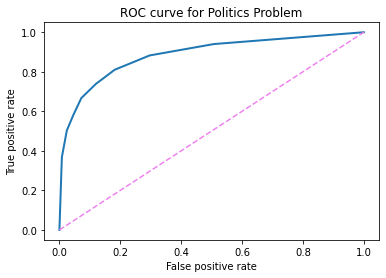

In [24]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Politics Problem');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))

### Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

pred = lr.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.6573
Precision: 0.5126
Recall: 0.0645
F1 Score: 0.1146

              precision    recall  f1-score   support

           0       0.66      0.97      0.79      3612
           1       0.51      0.06      0.11      1892

    accuracy                           0.66      5504
   macro avg       0.59      0.52      0.45      5504
weighted avg       0.61      0.66      0.56      5504



ROC AUC score =  0.83236895045643


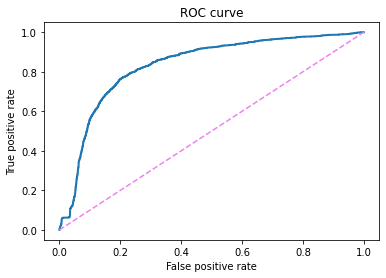

In [26]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))

### GaussianNB

In [27]:
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

pred = gnb.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.5331
Precision: 0.4216
Recall: 0.9635
F1 Score: 0.5866

              precision    recall  f1-score   support

           0       0.94      0.31      0.46      3612
           1       0.42      0.96      0.59      1892

    accuracy                           0.53      5504
   macro avg       0.68      0.64      0.53      5504
weighted avg       0.76      0.53      0.51      5504



ROC AUC score =  0.8163508003624282


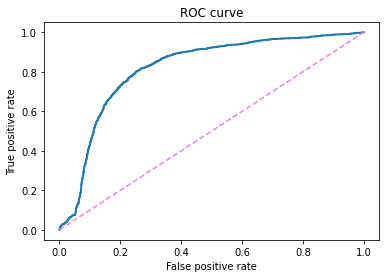

In [28]:
fpr, tpr, thresholds = roc_curve(y_val, gnb.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, gnb.predict_proba(X_val_scaled)[:,1]))

### Support Vector Classification

In [29]:
svc = SVC(probability=True)
svc.fit(X_train_scaled, y_train)

pred = svc.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.6564
Precision: 1.0000
Recall: 0.0005
F1 Score: 0.0011

              precision    recall  f1-score   support

           0       0.66      1.00      0.79      3612
           1       1.00      0.00      0.00      1892

    accuracy                           0.66      5504
   macro avg       0.83      0.50      0.40      5504
weighted avg       0.77      0.66      0.52      5504



ROC AUC score =  0.7840678622351148


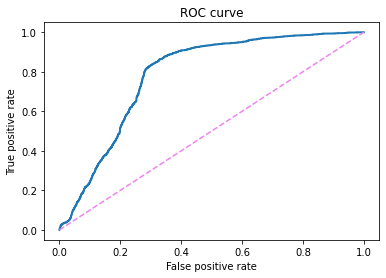

In [30]:
fpr, tpr, thresholds = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))

### DecisionTree

In [31]:
tree = DecisionTreeClassifier()
tree.fit(X_train_scaled, y_train)

pred = tree.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.8118
Precision: 0.7211
Recall: 0.7378
F1 Score: 0.7294

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      3612
           1       0.72      0.74      0.73      1892

    accuracy                           0.81      5504
   macro avg       0.79      0.79      0.79      5504
weighted avg       0.81      0.81      0.81      5504



ROC AUC score =  0.7943594173988981


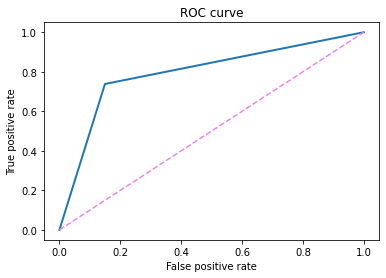

In [32]:
fpr, tpr, thresholds = roc_curve(y_val, tree.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, tree.predict_proba(X_val_scaled)[:,1]))

### RandomForest

In [33]:
forest = RandomForestClassifier()
forest.fit(X_train_scaled, y_train)

pred = forest.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.8670
Precision: 0.8598
Recall: 0.7326
F1 Score: 0.7911

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3612
           1       0.86      0.73      0.79      1892

    accuracy                           0.87      5504
   macro avg       0.86      0.83      0.85      5504
weighted avg       0.87      0.87      0.86      5504



ROC AUC score =  0.9201126471779528


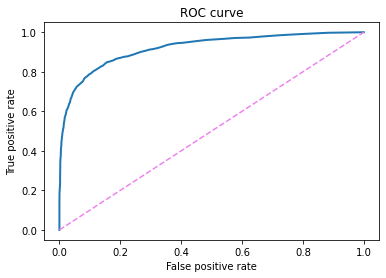

In [34]:
fpr, tpr, thresholds = roc_curve(y_val, forest.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, forest.predict_proba(X_val_scaled)[:,1]))

In [35]:
df2 = df.copy()

X = df2[features]
y = df2['bot']


# Resetting train/test split
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=37)

# Scaling
scalar = StandardScaler()
scalar.fit(X)

X_train_scaled = scalar.transform(X)
X_test_scaled = scalar.transform(X_test)

In [36]:
acc = cross_val_score(forest, X_train_scaled, y, cv=3, scoring='accuracy').mean()
prec = cross_val_score(forest, X_train_scaled, y, cv=3, scoring='precision').mean()
rec = cross_val_score(forest, X_train_scaled, y, cv=3, scoring='recall').mean()
f1 = cross_val_score(forest, X_train_scaled, y, cv=3, scoring='f1').mean()

print('Accuracy: {:.4f}'.format(acc))
print('Precision {:.4f}'.format(prec))
print('Recall {:.4f}'.format(rec))
print('F1 Score {:.4f}'.format(f1))

Accuracy: 0.8679
Precision 0.8477
Recall 0.7386
F1 Score 0.7855


In [37]:
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y, test_size=.3, random_state=42)

In [38]:
forest = RandomForestClassifier()
forest.fit(X_train_scaled, y_train)

forest_pred = forest.predict(X_val_scaled)

In [39]:
print(classification_report(y_val, forest_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5253
           1       0.84      0.74      0.79      2609

    accuracy                           0.87      7862
   macro avg       0.86      0.83      0.85      7862
weighted avg       0.87      0.87      0.87      7862



In [40]:
forest_cm = confusion_matrix(y_val, forest_pred)
forest_cm

array([[4897,  356],
       [ 685, 1924]])

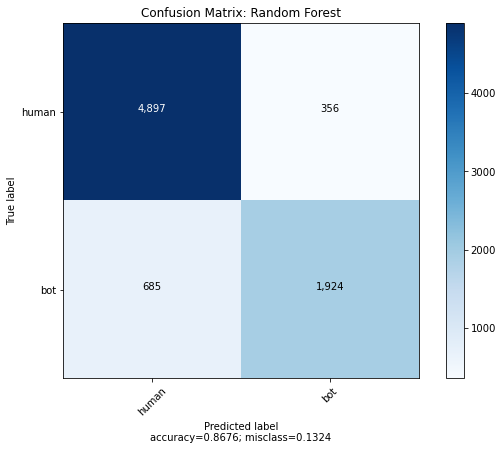

In [41]:
model = 'Random Forest'

plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], title='Confusion Matrix: {}'.format(model))

In [42]:
print("Training score: {:.6f}".format(forest.score(X_train_scaled, y_train)))
print("Validation score: {:.6f}".format(forest.score(X_val_scaled, y_val)))

Training score: 0.999891
Validation score: 0.867591


### XGBoost?